In [1]:
# Download dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

fatal: destination path 'Brain-Tumor-Classification-DataSet' already exists and is not an empty directory.


In [2]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Perform image augmentation to increase the size of the training dataset

In [3]:
train_datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = train_datagen.flow_from_directory('/content/Brain-Tumor-Classification-DataSet/Training', 
                                               target_size=(224, 224), 
                                               batch_size=32, 
                                               class_mode='categorical',
                                               subset='training')

valid_data = train_datagen.flow_from_directory('/content/Brain-Tumor-Classification-DataSet/Training', 
                                               target_size=(224, 224), 
                                               batch_size=32, 
                                               class_mode='categorical',
                                               subset='validation')

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [4]:
train_data.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

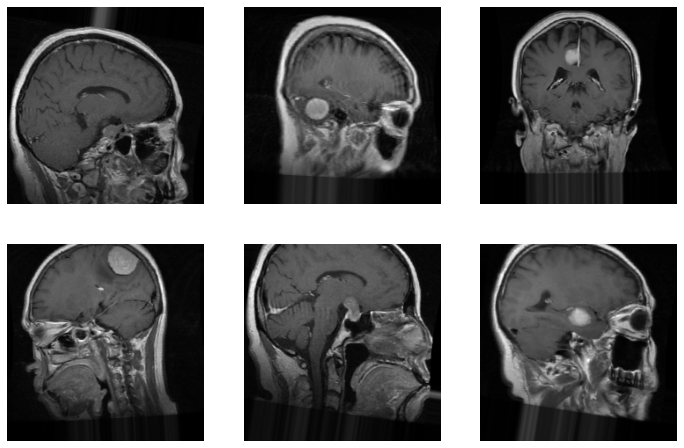

In [5]:
# View sample of the augmented images
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12,8))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

### Build our CNN model base on EfficientNetB1 model

In [6]:
EffNetB1 = EfficientNetB1(weights='imagenet', 
                          include_top=False,
                          input_shape=(224, 224, 3))
model = EffNetB1.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=EffNetB1.input, outputs=model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [7]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)

In [8]:
train_history = model.fit(train_data, epochs=10, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
72/72 [==============================] - 91s 1s/step - loss: 0.7632 - accuracy: 0.7127 - val_loss: 0.9779 - val_accuracy: 0.5899

Epoch 00001: val_accuracy improved from -inf to 0.58988, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
72/72 [==============================] - 66s 919ms/step - loss: 0.2960 - accuracy: 0.8981 - val_loss: 0.4909 - val_accuracy: 0.8482

Epoch 00002: val_accuracy improved from 0.58988 to 0.84817, saving model to model.h5
Epoch 3/10
72/72 [==============================] - 66s 918ms/step - loss: 0.1798 - accuracy: 0.9417 - val_loss: 0.3799 - val_accuracy: 0.8726

Epoch 00003: val_accuracy improved from 0.84817 to 0.87260, saving model to model.h5
Epoch 4/10
72/72 [==============================] - 67s 927ms/step - loss: 0.1158 - accuracy: 0.9621 - val_loss: 0.3545 - val_accuracy: 0.8691

Epoch 00004: val_accuracy did not improve from 0.87260
Epoch 5/10
72/72 [==============================] - 66s 919ms/step - loss: 0.0877 - accuracy: 0.9691 - val_loss: 0.3758 - val_accuracy: 0.8569

Epoch 00005: val_accuracy did not improve from 0.87260
Epoch 6/10
72/72 [==============================] - 66s 918ms/step - loss: 0.0624 - accuracy: 0.9817 - val_loss: 0.3558 - val_accuracy: 0.8778



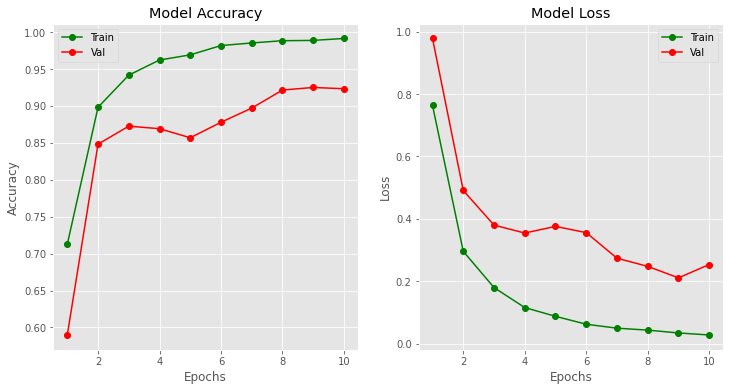

In [9]:
# Plot the training curves
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
epochs = range(1,11)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_history.history['accuracy'], 'go-')
plt.plot(epochs, train_history.history['val_accuracy'], 'ro-')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_history.history['loss'], 'go-')
plt.plot(epochs, train_history.history['val_loss'], 'ro-')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Evaluate model performance on the test dataset

In [10]:
test_datagen = ImageDataGenerator()
test_data = test_datagen.flow_from_directory('/content/Brain-Tumor-Classification-DataSet/Testing', 
                                             target_size=(224, 224), 
                                             class_mode='categorical')

Found 394 images belonging to 4 classes.


In [11]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print('\nTest accuracy:', test_accuracy)

13/13 - 3s - loss: 1.1111 - accuracy: 0.7919

Test accuracy: 0.7918781638145447
